# Assignment 2: Sentiment Classification Using Logistic Regression

Lin Shi

**In your own words, describe what the task is:**

For this assignment, the task is to train a binary logistic regression classifier and a Naive Bayes classifier for sentiment analysis. The task is highly valuable for various applications such as customer reviews, social media sentiment analysis, and opinion mining. In this assignment, we classify hotel reviews as positive or negative, a perfect example of how the task is valuable. 

**Describe your method for the task**

Four functions were created to implement the six different feature extraction (positive lexicon and negative lexicon share a function; find “no” and find “!” share a function). All features are relatively self-explanatory. For example, either the word exists in the positive document, or it does. However, counting the number of first and second-person pronouns may have different interpretations. Based on Walden University (Academic guides) and Cambridge dictionary (Pronouns: Possessive), I used the list of “I,” “my,” “mine,” “our,” “we,” “you,” and “your” as first and second-person pronouns. 

The initial weights are a hyperparameter tuned extensively on the logistic regression. Although we could randomly assign the values to it, it was clear that some of the features would impact our model positively (positive lexicon) or negatively (negative lexicon). On the other hand, some of the other features may not be as clear (pronouns, !, etc.). The feature vector \[3, -7, -1, 1, 0.2, 0.2\] was used in the end. 

Furthermore, I left all other parameters the way it is. The learning rate is at 0.01. The number of iterations is 100. The default algorithm was used for make_optimizer. The logit prediction is when logits >= 0.5. Lastly, given how the weight runs through the torch.sigmoid function, I decided to use the torch.nn.functional.binary_cross_entropy instead of the torch.nn.functional.binary_cross_entropy_with_logits when calculating the loss. 

**Experiment results**

|weights (bold is the one testing for)|    F1    | motivation                                         |
| ------------------------------------|----------|----------------------------------------------------|
|\[1, -1, -1, -0.5, -0.5, -1\]        | 0.58     | default, based on assumption                       |
|\[**2**, -1, -1, -0.5, -0.5, -1\]    | 0.82     | testing positive lexicon                           |
|\[1, **-2**, -1, -0.5, -0.5, -1\]    | 0.6      | testing negative lexicon                           |
|\[1, -1, **-2**, -0.5, -0.5, -1\]    | 0.62     | testing “no” feature                               |
|\[1, -1, -1, **0.5**, -0.5, -1\]     | 0.85     | testing pronoun feature on positive side           |
|\[1, -1, -1, **1.5**, -0.5, -1\]     | 0.79     | add more weight to the pronoun on the positive side| 
|\[1, -1, -1, -0.5, **0.5**, -1\]     | 0.62     | testing “!” feature on positive side               |
|\[1, -1, -1, -0.5, **1**, -1\]       | 0.62     | add more weight to “!”                             |
|\[1, -1, -1, -0.5, -0.5, **-2**\]    | 0.26     | testing log(word count)                            |
|\[1, -1, -1, -0.5, -0.5, **-0.5**\]  | 0.74     | test numbers that are closer to 0                  |
|\[1, -1, -1, -0.5, -0.5, **0.5**\]   | 0.79     | test weight that is the other side of sign         |

The motivation behind the testing is not the parameter tune but to find how these features correspond to the model. For example, when examining pronouns, initially, it is set to -0.5. Then, I tested it using 0.5, yielding better results. However, when I increased it to 1.5, I observed a decrease in the F1 score. Therefore, this process determines the importance of pronouns (compared to other features). Please note that there are far more tests; however, due to the space, a selective set of tests is presented to demonstrate the idea.  

In the end, after knowing the direction of the weights, I closely tuned them according to their F1 score. I added a print statement in the forward method to display how the weights increment. Therefore, in the end, I set with \[3, -7, -1, 1, 0.2, 0.2\], yielding a 0.8947 accuracy and 0.9047 F1 score for the development set. When running the test set, my accuracy was 0.88 and 0.89285 F1 score. Please note that I reran the whole file before submission so all output is visible; therefore, the result may vary slightly. 

**Discussion**

In the end, my models did relatively well. The logistic regression model resulted in a 0.9047 F1 score for the development set and a 0.89285 F1 score for the test set. The Naive Bayes classifier provided 0.809 for the development set and 0.888 F1 score for the test set. Naive Bayes and logistic regression is a simple and efficient algorithm for binary classification tasks. Naive Bayes is simply counting the number of positive words and the number of negative words. The logistic regression provides interpretable coefficients, which can be used to identify the important features for sentiment prediction. However, despite their effectiveness, Naive Bayes will likely fail when encountering brand-new entries. Logistic regression has limitations when dealing with complex, nonlinear relationships in data. It may miss subtle nuances in the sentiment. To further improve the current model, I would like to tune some other hyper-parameters such as batch size, number of iterations when training, and learning rate. Given how the direction and some of the posts on Piazza indicate not to change those codes, the best I can do is to tune the weights as a hyperparameter for this assignment. Additionally, we could explore more feature engineering. Based on the experiment, it was clear that the other four had little effect on the model compared to the positive and negative lexicon; therefore, it may be worthwhile to explore other possible features. 

**Citation**

Academic guides: Scholarly voice: Point of view. Point of View - Scholarly Voice - Academic Guides at Walden University. (n.d.). https://academicguides.waldenu.edu/writingcenter/scholarlyvoice/pointofview#:~:text=A%20paper%20using%20first%2Dperson,%2C%22%20and%20%22them.%22 

Pronouns: Possessive ( my, mine, your, yours, etc..). Pronouns: possessive ( my, mine, your, yours, etc.) - Cambridge Grammar. (n.d.). https://dictionary.cambridge.org/us/grammar/british-grammar/pronouns-possessive-my-mine-your-yours-etc 

## Programming Assignment (100 Points scaled to 40)

For this assignment we will be implementing a naive bayes baseline classifier. Additionally, we will be using pytorch to implement a binary logistic regression classifier. Our task is sentiment classification for hotel reviews. The input to your model will be a text review, and the output label is a 1 or 0 marking it as positive or negative.

In [1]:
from typing import List
import spacy
import torch
import random

## Section 1: Sentiment Classification Dataset (Total: 20 Points)

The training data for this task consists of a collection of short hotel reviews. The data is formatted as one review per line. Each line starts with a unique identifier for the review (as in ID-2001) followed by tab and the text of the review.  The reviews are not tokenized or sentence segmented in any way (the words are space separated). The positive reviews and negative reviews appear in separate files namely [hotelPosT-train.txt](data/hotelPosT-train.txt) and [hotelNegT-train.txt](data/hotelNegT-train.txt).

In [2]:
from util import load_train_data
pos_datapath = "data/hotelPosT-train.txt"
neg_datapath = "data/hotelNegT-train.txt"
all_texts, all_labels = load_train_data(pos_datapath, neg_datapath)

### Lets look at what is in the data

In [3]:
def random_sample(texts, labels, label):
    data_by_label = {}
    for lab, text in zip(labels, texts):
        if lab not in data_by_label:
            data_by_label[lab] = []
        data_by_label[lab].append(text)
    return random.choice(data_by_label[label])

print("--- Positive Example ---")
print(random_sample(all_texts, all_labels, label=1))
print("\n--- Negative Example ---")
print(random_sample(all_texts, all_labels, label=0))

--- Positive Example ---
America's Best Value Inn - Golden Gate is just that, a great value near Golden Gate Bridge. The hotel was located near several different bus stop lines, which made travel around the city very simple. The Golden Gate Bridge was about a ten minute ride away. As for the hotel itself, the staff was very friendly, they held our bags for us when we got there earlier then expected and also let us check in about two hours early after that. The room we booked was a King Suite and the size was great for only $50something per night. We joined their free discount club before we went, so the room was a great deal. The shower had plenty of hot water and the bathroom was clean. We had never been to San Francisco before and so we didn't spend too much time in the hotel but it was clean, the bed was large and comfortable and the staff was great. We plan on staying with them next time we travel to SF.

--- Negative Example ---
We didn't feel at home at the Crowne Plaza near the 

### Test Data ( WAIT TILL DEADLINE)

This is the test dataset that you will need to use to report the results on. This set is the unseen dataset meaning, you are not in anyway supoose to look what is in this dataset. We will release this dataset on the last day of the assignment's deadline.

In [4]:
### RUN THIS ONLY ON DEADLINE ###
# Load the test data

# from util import load_test_data

# # FIXME
# test_datapath = "data/test-dataset.txt"
# test_texts, test_labels = load_train_data(test_datapath)

from typing import List, Tuple, Any


def load_test_data(filepath: str) -> Tuple[List[Any], List[Any]]:
    """Load the test data, producing a List of texts, labels

    Args:
        filepath (str): Path to the training file

    Returns:
        Tuple[List[Any], List[Any]]: The texts and labels
    """
    lab_map = {'POS': 1, 'NEG': 0}
    texts = []
    labels = []
    with open(filepath, "r", encoding = 'utf-8') as file:
        for line in file:
            idx, text, label = line.rstrip().split("\t")
            texts.append(text)
            labels.append(lab_map[label])
    return texts, labels


test_texts, test_labels = load_test_data('./data/HW2-testset.txt')

### Task 1.1: Print the number of "positive" and "negative" samples (5 Points)

It is important to know the distribution of the training examples. More often than not, you will have to work with datasets that are not "balanced" with respect to the labels of the samples. For this task, print out the number of examples that have label = 1 and label = 0, respectively, in std:out or plot a pie chart.

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
postives:  95
total count:  189


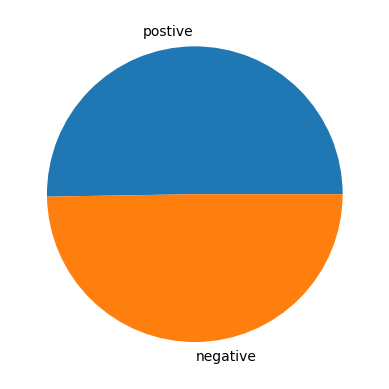

In [5]:
### ENTER CODE HERE ###

# Note since we have them in two seperate files, 
# this can also be done with bash commands
import matplotlib.pyplot as plt
def label_distribution(labels):
    """
    TODO: Replace the line `raise NotImplementedError` with your code
    to print the labels distribution.
    """
    
    print(labels)
    print("postives: " , sum(labels))
    print("total count: ", len(labels))
    data = [sum(1 for value in labels if value == 1), sum(1 for value in labels if value == 0)]
    plt.pie(data, labels = ["postive", "negative"])
    
label_distribution(all_labels)

### Task 1.2: Split Training and Development Sets (5 Points)

For the purpose of coming with the best parameters for the model you will have to split the dataset into training and development sets. Make sure the splits follow the same distribution.

Train Label Distribution:
[1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0]
postives:  76
total count:  151
Dev Label Distribution:
[1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1]
postives:  19
total count:  38


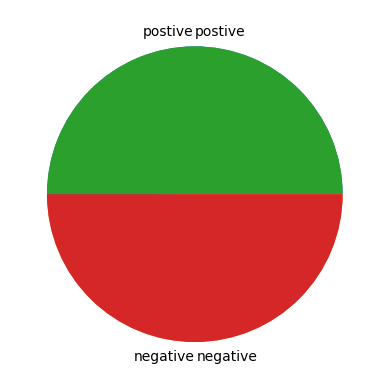

In [6]:
### ENTER CODE HERE ###
from sklearn.model_selection import train_test_split

def split_dataset(texts, labels):
    """
    Split the dataset randomly into 80% training and 20% development set
    Make sure the splits have the same label distribution
    """
    text_train, text_dev, label_train, label_dev = train_test_split(texts, labels, test_size = 0.2, stratify = labels)
    return text_train, label_train , text_dev, label_dev
    
train_texts, train_labels, dev_texts, dev_labels = split_dataset(all_texts, all_labels)

print('Train Label Distribution:')
label_distribution(train_labels)

print('Dev Label Distribution:')
label_distribution(dev_labels)

### Task 1.3: Evaluation Metrics (10 Points)

Implement the evaulation metrics: Accuracy, Precision, Recall and F1 score

In [7]:
### ENTER CODE HERE ###

def accuracy(predicted_labels, true_labels):
    """
    Accuracy is correct predictions / all predicitons
    """
    correct = 0 
    for i in range(len(predicted_labels)):
        if(predicted_labels[i] == true_labels[i]):
            correct += 1
    if(len(true_labels) == 0):
        return 0
    return correct/len(true_labels)

def precision(predicted_labels, true_labels):
    """
    Precision is True Positives / All Positives Predictions
    """
    actualTrue = 0
    predictedTrue = 0
    for i in range(len(predicted_labels)):
        if(predicted_labels[i] == 1):
            predictedTrue += 1
            if(true_labels[i] == 1):
                actualTrue += 1
    if(predictedTrue == 0):
        return 0
    return actualTrue/predictedTrue

def recall(predicted_labels, true_labels):
    """
    Recall is True Positives / All Positive Labels
    """
    postiveLabels = 0
    truePostive = 0
    for i in range(len(true_labels)):
        if(true_labels[i] == 1):
            postiveLabels +=1 
            if(predicted_labels[i] == 1):
                truePostive += 1
    if(postiveLabels == 0):
        return 0
    return truePostive/postiveLabels

def f1_score(predicted_labels, true_labels):
    """
    F1 score is the harmonic mean of precision and recall
    """
    precisionScore = precision(predicted_labels, true_labels)
    recallScore = recall(predicted_labels, true_labels)
    # print("score")
    # print(precisionScore) 
    # print(recallScore)
    # print("labels")
    # print(predicted_labels)
    # print(true_labels)
    if(precisionScore == 0 and recallScore == 0):
        return 0
    return (2 * precisionScore * recallScore)/ (precisionScore + recallScore)

In [8]:
### DO NOT EDIT ###

em_test_labels = [0]*6 + [1]*4
em_test_predictions = [0]*8 + [1]*2

em_test_accuracy = 0.8
em_test_precision = 1.0
em_test_recall = 0.5
em_test_f1 = 2/3

assert accuracy(em_test_predictions, em_test_labels) == em_test_accuracy
assert precision(em_test_predictions, em_test_labels) == em_test_precision 
assert recall(em_test_predictions, em_test_labels) == em_test_recall
assert f1_score(em_test_predictions, em_test_labels) == em_test_f1

print('All Test Cases Passed!')

All Test Cases Passed!


## Section 2: Baselines (Total: 20 Points)

It is important to come up with baselines for the classifications to compare the more complicated models with. The baselines are also useful as a debugging method for your actual classfication model. You will create two baselines:

1. Random Chance
2. Naive Bayes Classifier

### Task 2.1: Random Chance Classifier (5 Points)

A random chance classifier predicts the label according to the label's distribution. As an example, if the label 1 appears 70% of the times in the training set, you predict 70 out of 100 times the label 1 and label 0 30% of the times

In [9]:
### ENTER CODE HERE ###
import random
def predict_random(train_labels, num_samples):
    """
    Using the label distribution, predict the label num_sample number of times
    """
    percentage = (sum(train_labels))/(len(train_labels))
    prediction = []
    for i in range(num_samples):
        randomNumber = random.random()
        if(randomNumber <= percentage):
            prediction.append(1)
        else:
            prediction.append(0)
    return prediction

### Task 2.2: Naive Bayes Classifier (Total: 10 Points)

In the class, Jim went over how to implement a Naive Bayes Classifier using the tokens in the training samples.
In this task, you will do the same. As a preprocessing step, you might want to remove the stop words and lemmatize/stem the words of the texts. 

### Spacy Model https://spacy.io

To tokenize the text and help extract features from text, we will use the popular spaCy model

In [10]:
### DO NOT EDIT ###

# Initialize the spacy model
nlp = spacy.load('en_core_web_sm')

### Task 2.2.1: Play around with spacy (0 Points)

In [11]:
### ENTER CODE HERE ###

test_string = "This is an amazing sentence"

# parse the string with spacy model
test_doc = nlp(test_string)

print('Token', 'Lemma', 'Is_Stopword?')
for token in test_doc:
    print(token, token.lemma_, token.is_stop)

Token Lemma Is_Stopword?
This this True
is be True
an an True
amazing amazing False
sentence sentence False


### Task 2.2.2: Preprocessing (5 Points)

Remove stopwords and lemmatize the words of a text

In [12]:
### ENTER CODE HERE ###

def pre_process(text: str) -> List[str]:
    """
    remove stopwords and lemmatize and return an array of lemmas
    """
    tempText = nlp(text)
    textList = []
    for token in tempText:
        if not (token.is_stop):
            textList.append(token.lemma_)
    return textList
    
test_string = "This sentence needs to be lemmatized"

assert len({'sentence', 'need', 'lemmatize', 'lemmatiz'}.intersection(pre_process(test_string))) >= 3

print('All Test Cases Passed!')

All Test Cases Passed!


### Task 2.2.3: The Naive Bayes Class (5 Points)

The standard way of implementing classifiers like Naive Bayes is to implement the two methods: "fit" and "predict". The fit method expects the training data along with labels, and the predict method predicts the labels for the provides texts of samples.

In [13]:
### ENTER CODE HERE ###
import math

# added log_prior based on the pseudocode in the reading (figure 4.2)
class NaiveBayesClassifier:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.label_word_counter = {}
        self.vocab = []
        self.prior_class = {}
        self.likelihood = {}
    
    def fit(self, texts, labels):
        """
        1. Group samples by their labels
        2. Preprocess each text
        3. Count the words of the text for each label
        """
        for label in range(self.num_classes):
            self.label_word_counter[label] = {}
            self.prior_class[label] = math.log(labels.count(label)/ len(texts))
    
        for i in range(len(texts)):
            label = labels[i]
            text = texts[i]
            
            preprocessed_text = pre_process(text)
            
            for word in preprocessed_text:
                if word not in self.label_word_counter[label]:
                    self.label_word_counter[label][word] = 0
                    if word not in self.vocab:
                        self.vocab.append(word)
                self.label_word_counter[label][word] += 1
        
    def predict(self, texts):
        """
        1. Preprocess the texts
        2. Predict the class by using the likelihood with Bayes Method and Laplace Smoothing
        """
        prediction = []
        
        for text in texts:
            preprocessed_text = pre_process(text)
            prediction_liklihood = -float('inf')
            
            for label in range(self.num_classes):
                likelihood = 1.0
                for word in preprocessed_text:
                    word_count = self.label_word_counter[label].get(word, 0)
                    
                    smoothed_likelihood = math.log((word_count + 1) / (sum(self.label_word_counter) + len(self.vocab))) 
                    likelihood += smoothed_likelihood 
                    
                postLikelihood = self.prior_class[label] + likelihood
                if postLikelihood > prediction_liklihood:
                    prediction_liklihood = postLikelihood
                    prediction_class = label
            prediction.append(prediction_class)
            
        return prediction
            

### Task 2.3: Baseline Results  (5 Points)

Since there is not hyperparameter-tuing required for the baselines, we can use the entirety of the training set (no need to split the dataset into train and development). Report the results you achieve with the two baselines by running the following cell:

In [14]:
### DO NOT EDIT ###

### DEV SET RESULTS

testset_prediction_random = predict_random(train_labels, num_samples=len(dev_labels))
print('Random Chance F1:', f1_score(testset_prediction_random, dev_labels))

naive_bayes_classifier = NaiveBayesClassifier(num_classes=2)
naive_bayes_classifier.fit(train_texts, train_labels)
testset_predictions_nb = naive_bayes_classifier.predict(dev_texts)
print('Naive Bayes F1:', f1_score(testset_predictions_nb, dev_labels))

Random Chance F1: 0.42857142857142855
Naive Bayes F1: 0.8780487804878049


In [15]:
### DO NOT EDIT ###
### RUN THIS ONLY ON DEADLINE ###
### TEST SET RESULTS

testset_prediction_random = predict_random(all_labels, num_samples=len(test_labels))
print('Random Chance F1:', f1_score(testset_prediction_random, test_labels))

naive_bayes_classifier = NaiveBayesClassifier(num_classes=2)
naive_bayes_classifier.fit(all_texts, all_labels)
testset_predictions_nb = naive_bayes_classifier.predict(test_texts)
print('Naive Bayes F1:', f1_score(testset_predictions_nb, test_labels))

Random Chance F1: 0.47058823529411764
Naive Bayes F1: 0.888888888888889


## Section 3: Logistic Regression on Features (Total: 60 Points)

Now let's try building a logistic regression based classifier on hand-engineered features.

The following tasks are going to be the implementation of the components required in building a Logistic Regressor.

### Task 3.0: Feature Extraction (20 points)

This is perhaps the most challenging part of this assignment. In the class, we went over how to featurize text for a classification system for sentiment analysis. In this assignment, you should implement and build upon this to accuractely classify the hotel reviews.

This task requires a thorough understanding of the dataset to answer the important question, "What is in the data?". Please go through some of the datapoints and convert the signals that you think might help in identifying "sentiment" as features.

Please refer to the section in Jim's book that illustrates the process of feature engineering for this task. We have attached an image of the table below:

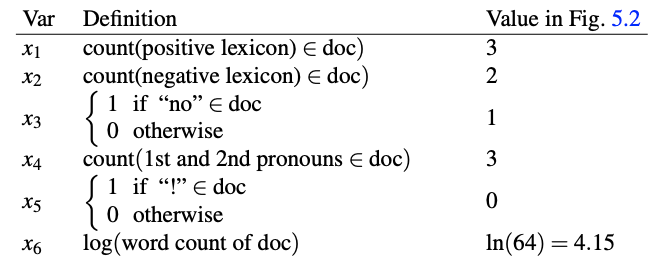

Please use the files with postive and negative words attached in the assignment: [positive_words.txt](data/poisitive-words.txt) and  [negative_words.txt](data/negative-words.txt)

In [16]:
def make_test_feature(text: spacy.tokens.doc.Doc):
    return "happy" in [t.lemma_ for t in text]

import math

def compareWords(text: spacy.tokens.doc.Doc, filepath):
    word_set = []
    score = 0
    with open(filepath, "r", encoding = 'utf-8') as file:
        for line in file:
            word = line.strip()
            word_set.append(word)
        for t in text:
            if(t.lemma_ in word_set):
                score += 1 
    return score

def findWord(text: spacy.tokens.doc.Doc, word):
    count = 0
    for t in text:
        if(t.lemma_ == word):
            count += 1
    return count

def findPronouns(text: spacy.tokens.doc.Doc):
    first_person = ["I", "my", "mine", "our", "we"]
    second_person = ["you", "your"]
    count = 0 
    for t in text:
        if(t.lemma_ in first_person or t.lemma_ in second_person):
            count += 1
    return count 

def findLogWordCount(text: spacy.tokens.doc.Doc):
    return math.log(len(text))

def extract_features(text: spacy.tokens.doc.Doc):
    features = []
    # TODO: Replace this with your own feature extraction functions.
    # features.append(make_test_feature(text))
    features.append(compareWords(text, "data/positive-words.txt"))
    features.append(compareWords(text, "data/negative-words.txt"))
    features.append(findWord(text, "no"))
    features.append(findPronouns(text))
    features.append(findWord(text, "!"))
    features.append(findLogWordCount(text))
    
    return features

In [17]:
### ENTER CODE HERE ###
### DO NOT CHANGE THE SIGNATURE OF THE function THOUGH ###

def featurize_data(texts, labels):
    features = [
        extract_features(doc) for doc in nlp.pipe(texts)
    ]
    return torch.FloatTensor(features), torch.FloatTensor(labels)

### Task 3.0.2: Feature Scaling (10 Points)

In this task we will use the data normalization technique to ensure the scales of the feature are consistent.
After featurizing the dataset, we need to call the following function before passing it to the classifier

#### Normalization Formula

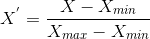

In [18]:
### ENTER CODE HERE ###

def normalize(features: torch.Tensor) -> torch.Tensor:
    """
    return the features transformed by the above formula of normalization
    """
    min_value = torch.min(features)
    max_value = torch.max(features)
    normalized_features = (features - min_value) / (max_value - min_value) 
    return normalized_features

## Training a Logistic Regression Classifier (Total: 30 Points)

In this section, you will implement the components needed to train the binary classifier using logistic regression

### Here we define our pytorch logistic regression classifier (DO NOT EDIT THIS)

In [19]:
class SentimentClassifier(torch.nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        # We force output to be one, since we are doing binary logistic regression
        self.output_size = 1
        self.coefficients = torch.nn.Linear(input_dim, self.output_size)
        # Initialize weights. Note that this is not strictly necessary,
        # but you should test different initializations per lecture
        initialize_weights(self.coefficients)
        
    def forward(self, features: torch.Tensor):
        # We predict a number by multipling by the coefficients
        # and then take the sigmoid to turn the score as logits
        # print(self.coefficients.weight.data)
        return torch.sigmoid(self.coefficients(features))

### Task 3.1: Initialize the weights. (5 Points)

Initialization of the parameters is an important step to ensure the SGD algorithm converges to a global optimum. Typically, we need to try different initialization methods and compare the accuracy we achieve for the development set. In this task, implement the function that initializes the parameters to ...

In [20]:
### ENTER CODE HERE ###
import random
def initialize_weights(coefficients):
    """
    TODO: Replace the line `raise NotImplementedError` with your code.
    Initialize the weights of the coefficients by assigning the parameter
    coefficients.weights.data = ...
    """
#     test = []
#     for i in range(6):
#         test.append(random.uniform(-1,1))
        
    # coefficients.weight.data = torch.tensor([[2, -2, -1.5, 0.5, 1, 1]])
    
    coefficients.weight.data = torch.tensor([[3, -7, -1, 1, 0.2, 0.2]])
    coefficients.bias.data = torch.tensor([0.1])
    return coefficients

Let's build a training function similar to the linear regressor from the tutorial

### Task 3.2: Logistic Loss Function (10 Points)

In [21]:
### ENTER CODE HERE ###

def logistic_loss(prediction: torch.Tensor, label: torch.Tensor) -> torch.Tensor:
    """
    TODO: Implement the logistic loss function between a prediction and label.
    """

    loss = torch.nn.functional.binary_cross_entropy(prediction, label.float())
    return loss

### Task 3.3: Create an SGD optimizer (0 Points)

We have already provided the implementation of how to create the SGD optimizer

You may try different optimizers refering to the docs provided

In [22]:
### ENTER CODE HERE ###

def make_optimizer(model, learning_rate) -> torch.optim:
    """
    Returns an Stocastic Gradient Descent Optimizer
    See here for algorithms you can import: https://pytorch.org/docs/stable/optim.html
    """
    return torch.optim.SGD(model.parameters(), learning_rate)

### Task 3.5: Converting Logits into Predictions (5 Points)

In [23]:
### ENTER CODE HERE ###

def predict(model, features):
    with torch.no_grad():
        """
        TODO: Replace the line `raise NotImplementedError`
        with the logic of converting the logits into prediction labels (0, 1)
        """
        logits = model(features)
        # print(logits)
        predictions = logits >= 0.50
        return predictions

### Training Function (DO NOT EDIT THIS)

In [24]:
### DO NOT EDIT ###

from tqdm.autonotebook import tqdm
import random


def training_loop(
    num_epochs,
    batch_size,
    train_features,
    train_labels,
    dev_features,
    dev_labels,
    optimizer,
    model
):
    samples = list(zip(train_features, train_labels))
    random.shuffle(samples)
    batches = []
    for i in range(0, len(samples), batch_size):
        batches.append(samples[i:i+batch_size])
    print("Training...")
    for i in range(num_epochs):
        losses = []
        for batch in tqdm(batches):
            # Empty the dynamic computation graph
            features, labels = zip(*batch)
            features = torch.stack(features)
            labels = torch.stack(labels)
            optimizer.zero_grad()
            # Run the model
            logits = model(features)
            # Compute loss
            loss = logistic_loss(torch.squeeze(logits), labels)
            # In this logistic regression example,
            # this entails computing a single gradient
            loss.backward()
            # Backpropogate the loss through our model
            
            # Update our coefficients in the direction of the gradient.
            optimizer.step()
             # For logging
            losses.append(loss.item())
        
        # Estimate the f1 score for the development set
        dev_f1 = f1_score(predict(model, dev_features), dev_labels)
        print(f"epoch {i}, loss: {sum(losses)/len(losses)}")
        print(f"Dev F1 {dev_f1}")
        
    # Return the trained model
    return model

C:\Users\linsh\AppData\Local\Temp\ipykernel_32924\1486293614.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Task 3.6: Train the classifier (10 Points)

Run the following cell to train a logistic regressor on your hand-engineered features.

In [25]:
### DO NOT EDIT ###

num_epochs = 100

train_features, train_labels_tensor = featurize_data(train_texts, train_labels)
train_features = normalize(train_features)
dev_features, dev_labels_tensor = featurize_data(dev_texts, dev_labels)
dev_features = normalize(dev_features)
model = SentimentClassifier(train_features.shape[1]) 
optimizer = make_optimizer(model, learning_rate=0.01)

trained_model = training_loop(
    num_epochs,
    16,
    train_features,
    train_labels_tensor,
    dev_features,
    dev_labels_tensor,
    optimizer,
    model
)

Training...


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 0, loss: 0.4846216291189194
Dev F1 0.8636363636363636


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 1, loss: 0.4844217777252197
Dev F1 0.8636363636363636


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 2, loss: 0.4842285245656967
Dev F1 0.8636363636363636


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 3, loss: 0.48404155671596527
Dev F1 0.8636363636363636


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 4, loss: 0.48386057913303376
Dev F1 0.8636363636363636


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 5, loss: 0.48368531465530396
Dev F1 0.8636363636363636


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 6, loss: 0.48351554572582245
Dev F1 0.8636363636363636


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 7, loss: 0.48335100710392
Dev F1 0.8636363636363636


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 8, loss: 0.4831914395093918
Dev F1 0.8636363636363636


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 9, loss: 0.48303661942481996
Dev F1 0.8636363636363636


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 10, loss: 0.48288634717464446
Dev F1 0.8636363636363636


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 11, loss: 0.4827404260635376
Dev F1 0.8636363636363636


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 12, loss: 0.4825986325740814
Dev F1 0.8837209302325582


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 13, loss: 0.48246081471443175
Dev F1 0.8837209302325582


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 14, loss: 0.4823267698287964
Dev F1 0.8837209302325582


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 15, loss: 0.4821963131427765
Dev F1 0.8837209302325582


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 16, loss: 0.4820692926645279
Dev F1 0.8837209302325582


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 17, loss: 0.48194554448127747
Dev F1 0.8837209302325582


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 18, loss: 0.4818249523639679
Dev F1 0.8837209302325582


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 19, loss: 0.4817073494195938
Dev F1 0.8837209302325582


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 20, loss: 0.4815925985574722
Dev F1 0.8837209302325582


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 21, loss: 0.4814805924892426
Dev F1 0.8837209302325582


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 22, loss: 0.4813711762428284
Dev F1 0.8837209302325582


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 23, loss: 0.4812642604112625
Dev F1 0.8837209302325582


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 24, loss: 0.48115970492362975
Dev F1 0.8837209302325582


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 25, loss: 0.4810574173927307
Dev F1 0.8837209302325582


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 26, loss: 0.48095728158950807
Dev F1 0.8837209302325582


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 27, loss: 0.4808592349290848
Dev F1 0.8837209302325582


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 28, loss: 0.4807631254196167
Dev F1 0.8837209302325582


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 29, loss: 0.4806689083576202
Dev F1 0.8837209302325582


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 30, loss: 0.48057652115821836
Dev F1 0.8837209302325582


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 31, loss: 0.4804858177900314
Dev F1 0.8837209302325582


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 32, loss: 0.48039676547050475
Dev F1 0.8837209302325582


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 33, loss: 0.48030926287174225
Dev F1 0.8837209302325582


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 34, loss: 0.480223274230957
Dev F1 0.8837209302325582


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 35, loss: 0.4801387101411819
Dev F1 0.8837209302325582


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 36, loss: 0.48005549907684325
Dev F1 0.8837209302325582


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 37, loss: 0.479973578453064
Dev F1 0.8837209302325582


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 38, loss: 0.4798929482698441
Dev F1 0.9047619047619047


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 39, loss: 0.4798134475946426
Dev F1 0.9047619047619047


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 40, loss: 0.47973511815071107
Dev F1 0.9047619047619047


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 41, loss: 0.47965784966945646
Dev F1 0.9047619047619047


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 42, loss: 0.47958163917064667
Dev F1 0.9047619047619047


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 43, loss: 0.47950638830661774
Dev F1 0.9047619047619047


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 44, loss: 0.47943210005760195
Dev F1 0.9047619047619047


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 45, loss: 0.4793586999177933
Dev F1 0.9268292682926829


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 46, loss: 0.47928619384765625
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 47, loss: 0.479214483499527
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 48, loss: 0.47914355993270874
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 49, loss: 0.47907339930534365
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 50, loss: 0.4790039360523224
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 51, loss: 0.47893521189689636
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 52, loss: 0.4788671135902405
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 53, loss: 0.47879962623119354
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 54, loss: 0.47873277962207794
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 55, loss: 0.47866645753383635
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 56, loss: 0.4786007165908813
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 57, loss: 0.4785354733467102
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 58, loss: 0.47847074568271636
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 59, loss: 0.4784065008163452
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 60, loss: 0.4783427298069
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 61, loss: 0.478279373049736
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 62, loss: 0.4782164603471756
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 63, loss: 0.4781539112329483
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 64, loss: 0.47809178829193116
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 65, loss: 0.47803001999855044
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 66, loss: 0.4779686123132706
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 67, loss: 0.4779075413942337
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 68, loss: 0.4778467923402786
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 69, loss: 0.4777863472700119
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 70, loss: 0.4777261853218079
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 71, loss: 0.4776663243770599
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 72, loss: 0.4776067525148392
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 73, loss: 0.4775474280118942
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 74, loss: 0.47748835682868956
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 75, loss: 0.47742953300476076
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 76, loss: 0.47737092077732085
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 77, loss: 0.4773125261068344
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 78, loss: 0.47725436091423035
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 79, loss: 0.47719641625881193
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 80, loss: 0.4771386444568634
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 81, loss: 0.4770810753107071
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 82, loss: 0.47702366709709165
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 83, loss: 0.47696643471717837
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 84, loss: 0.47690936625003816
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 85, loss: 0.4768524765968323
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 86, loss: 0.47679573893547056
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 87, loss: 0.47673913836479187
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 88, loss: 0.4766826808452606
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 89, loss: 0.4766263335943222
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 90, loss: 0.4765701711177826
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 91, loss: 0.47651413083076477
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 92, loss: 0.4764581978321075
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 93, loss: 0.4764023721218109
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 94, loss: 0.47634668052196505
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 95, loss: 0.4762910693883896
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 96, loss: 0.4762356042861938
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 97, loss: 0.4761801928281784
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 98, loss: 0.47612490952014924
Dev F1 0.9500000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 99, loss: 0.4760697364807129
Dev F1 0.9500000000000001


### Task 3.7: Get the predictions on the Test Set using the Trained model and print the F1 score (10 Points)

In [26]:
### DO NOT EDIT ###

### DEV SET RESULTS

test_features, test_labels_dev = featurize_data(dev_texts, dev_labels)
print('Logistic Regression Results:')
print('Accuracy:', accuracy(predict(trained_model, test_features), test_labels_dev))
print('F1-score', f1_score(predict(trained_model, test_features), test_labels_dev))

Logistic Regression Results:
Accuracy: 0.8947368421052632
F1-score 0.9047619047619047


In [27]:
### DO NOT EDIT ###
### RUN THIS ONLY ON DEADLINE ###
### TEST SET RESULTS

test_features, test_labels = featurize_data(test_texts, test_labels)
print('Logistic Regression Results:')
print('Accuracy:', accuracy(predict(trained_model, test_features), test_labels))
print('F1-score', f1_score(predict(trained_model, test_features), test_labels))

Logistic Regression Results:
Accuracy: 0.86
F1-score 0.8771929824561403


## Written Assignment (60 Points)

Written assignment tests the understanding of the student for the assignment's task. We have split the writing into sections. You will need to write 1-2 paragraphs describing the sections. Please be concise.

### In your own words, describe what the task is (20 points)

Describe the task, how is it useful and an example.

### Describe your method for the task (10 points)

Important details about the implementation. Feature engineering, parameter choice etc.

### Experiment Results (10 points)

Typically a table summarizing all the different experiment results for various parameter choices

### Discussion (20 points)

Key takeaway from the assignment. Why is the method good? shortcomings? how would you improve? Additional thoughts?